In [0]:
import pandas as pd

data = pd.read_csv('/Data/Ankidroid_bow_features.csv', dtype={'is_vulnerable': bool})
data['is_vulnerable'] = data['is_vulnerable'].map({False: 0, True: 1})


In [0]:
x = data.loc[:, data.columns != 'is_vulnerable']
y = data['is_vulnerable']
SEQUENCE_LENGTH = x.shape[1]

In [0]:
from sklearn.model_selection import train_test_split
TEST_SPLIT = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SPLIT, random_state=42)

In [0]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

# Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Random forest
random_forest_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
random_forest_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [73]:
print("TRAIN")

predicted_rf = random_forest_classifier.predict(x_train)
predicted_prob_rf = random_forest_classifier.predict_proba(x_train)

confusion = sklearn.metrics.confusion_matrix(y_true=y_train, y_pred=predicted_rf)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=predicted_rf)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_train, y_pred=predicted_rf)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_train, y_pred=predicted_rf)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_train, y_pred=predicted_rf)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_train, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_train, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_train, y_pred=predicted_rf)))

TRAIN
[[ 86   1]
 [  1 135]]

TP: 135
FP: 1
TN: 86
FN: 1

Accuracy: 0.9910313901345291
Precision: 0.9926470588235294
Recall: 0.9926470588235294
F-measure: 0.9926470588235294
False Positive Rate:0.011494252873563218
AUC: 0.9905764029749831
Precision-Recall AUC: 0.9898324883237389
MCC: 0.9811528059499662


In [74]:
print("TEST")


predicted_rf = random_forest_classifier.predict(x_test)
predicted_prob_rf = random_forest_classifier.predict_proba(x_test)

confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted_rf)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted_rf)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted_rf)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted_rf)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted_rf)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted_rf)))

TEST
[[23  3]
 [ 2 28]]

TP: 28
FP: 3
TN: 23
FN: 2

Accuracy: 0.9107142857142857
Precision: 0.9032258064516129
Recall: 0.9333333333333333
F-measure: 0.9180327868852459
False Positive Rate:0.11538461538461539
AUC: 0.908974358974359
Precision-Recall AUC: 0.8787250384024577
MCC: 0.8205830201566422


#Resnet

In [0]:
def bn_relu(layer, dropout=0, **params):
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.Activation(params['conv_activation'])(layer)

    if dropout > 0:
        layer = tf.keras.layers.Dropout(dropout)(layer)
    return layer

In [0]:
def resnet_block(layer, filters, kernels, dropout, activation,
                 cross_block=False, is_first=False, is_last=False, shrink=False):
  # -BN-Act-Conv-BN-Act-Conv--
  # ↳-----------------------↑
  strides = 1
  if shrink:
    strides = 2
  if cross_block:
    shortcut = tf.keras.layers.Conv1D(filters=filters,
                      kernel_size=strides,
                      kernel_initializer='random_uniform',
                      # kernel_regularizer=regularizers.l2(0.01),
                      strides=strides,
                      padding='same')(layer)
  else:
    shortcut = layer

  if not is_first:
    layer = bn_relu(layer, dropout=dropout, conv_activation=activation)

  layer = tf.keras.layers.Conv1D(filters=filters,
                 kernel_size=kernels,
                 kernel_initializer='random_uniform',
                 # kernel_regularizer=regularizers.l2(0.01),
                 strides=strides,
                 padding='same')(layer)
  layer = bn_relu(layer, dropout=dropout, conv_activation=activation)
  layer = tf.keras.layers.Conv1D(filters=filters,
                 kernel_size=kernels,
                 kernel_initializer='random_uniform',
                 # kernel_regularizer=regularizers.l2(0.01),
                 strides=1,
                 padding='same')(layer)
  layer = tf.keras.layers.add([shortcut, layer])

  if is_last:
    layer = bn_relu(layer, dropout=dropout, conv_activation=activation)

  return layer

In [77]:
'''create model'''

OUTPUT_SHAPE = 2
input = tf.keras.layers.Input(shape=(1,SEQUENCE_LENGTH))

layer = tf.keras.layers.Conv1D(filters=32,
               kernel_size=3,
               kernel_initializer='random_uniform',
               # kernel_regularizer=regularizers.l2(0.01),
               strides=1,
               padding='same')(input)


layer = resnet_block(layer=layer, filters=32, kernels=3, dropout=0, activation='relu')

layer = resnet_block(layer, 64, 3, 0, 'relu', cross_block=True, shrink=True)
layer = resnet_block(layer, 64, 3, 0, 'relu')

layer = resnet_block(layer, 128, 3, 0, 'relu', cross_block=True, shrink=True)
layer = resnet_block(layer, 128, 3, 0, 'relu')

layer = resnet_block(layer, 256, 3, 0, 'relu', cross_block=True, shrink=True)
layer = resnet_block(layer, 256, 3, 0, 'relu')
layer = tf.keras.layers.Flatten()(layer)
output = tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation='softmax')(layer)

model = tf.keras.Model(inputs=[input], outputs=[output])

optimizer = tf.keras.optimizers.Adam(lr=0.005)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-3, patience=25, mode='auto', restore_best_weights=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 500)]     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 1, 32)        48032       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 1, 32)        128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 1, 32)        0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [0]:
BATCH_SIZE = 150
EPOCHS = 100
VALIDATION_SPLIT = 0.1

In [79]:
y_train

261    0
124    1
33     0
86     0
265    0
      ..
188    0
71     1
106    1
270    1
102    1
Name: is_vulnerable, Length: 223, dtype: int64

In [0]:
x_train_reshaped = np.array(x_train).reshape(-1, 1, SEQUENCE_LENGTH) 
y_train_reshaped = np.eye(2)[y_train]

x_test_reshaped =  np.array(x_test).reshape(-1, 1, SEQUENCE_LENGTH) 
y_test_reshaped = np.eye(2)[y_test]

In [82]:
model.fit(x_train_reshaped,
          y_train_reshaped,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=VALIDATION_SPLIT,
          callbacks=[monitor])

Train on 200 samples, validate on 23 samples
Epoch 1/100
200/200 [==============================] - 2s 12ms/sample - loss: 2.2944 - acc: 0.5950 - val_loss: 0.6513 - val_acc: 0.7391
Epoch 2/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.7430 - acc: 0.6150 - val_loss: 0.7290 - val_acc: 0.3478
Epoch 3/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.8676 - acc: 0.5950 - val_loss: 0.5796 - val_acc: 0.7391
Epoch 4/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.5754 - acc: 0.5950 - val_loss: 0.5318 - val_acc: 0.7391
Epoch 5/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.5288 - acc: 0.6500 - val_loss: 0.5622 - val_acc: 0.7391
Epoch 6/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.3851 - acc: 0.8350 - val_loss: 0.6011 - val_acc: 0.7826
Epoch 7/100
200/200 [==============================] - 0s 2ms/sample - loss: 0.4074 - acc: 0.8400 - val_loss: 0.6087 - val_acc: 0.6522
Epoch 8/1

In [83]:
print("TRAIN")

results = model.evaluate(x_train_reshaped, y_train_reshaped, batch_size=BATCH_SIZE)

for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted_prob = model.predict(x_train_reshaped)
predicted = np.argmax(predicted_prob,axis = 1)

confusion = sklearn.metrics.confusion_matrix(y_true=y_train, y_pred=predicted)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_train, y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_train, y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_train, y_pred=predicted)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_train, y_score=np.argmax(predicted_prob,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_train, y_score=np.argmax(predicted_prob,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_train, y_pred=predicted)))

TRAIN
223/223 [==============================] - 0s 161us/sample - loss: 0.4839 - acc: 0.8520
loss: 0.48385296568207675
acc: 0.85201794
[[ 60  27]
 [  6 130]]

TP: 130
FP: 27
TN: 60
FN: 6

Accuracy: 0.852017937219731
Precision: 0.8280254777070064
Recall: 0.9558823529411765
F-measure: 0.8873720136518771
False Positive Rate:0.3103448275862069
AUC: 0.8227687626774849
Precision-Recall AUC: 0.8184007715222275
MCC: 0.689808878046755


In [84]:
print("TEST")

results = model.evaluate(x_test_reshaped, y_test_reshaped, batch_size=BATCH_SIZE)

for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted_prob = model.predict(x_test_reshaped)
predicted = np.argmax(predicted_prob,axis = 1)

# predicted = model.predict_classes(x_test_reshaped)
# predicted_prob = model.predict(x_test_reshaped)

confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted)))

TEST
56/56 [==============================] - 0s 185us/sample - loss: 0.5350 - acc: 0.8036
loss: 0.535033106803894
acc: 0.8035714
[[16 10]
 [ 1 29]]

TP: 29
FP: 10
TN: 16
FN: 1

Accuracy: 0.8035714285714286
Precision: 0.7435897435897436
Recall: 0.9666666666666667
F-measure: 0.8405797101449275
False Positive Rate:0.38461538461538464
AUC: 0.7910256410256411
Precision-Recall AUC: 0.7366605616605617
MCC: 0.631323255446602


# SVM

In [85]:
from sklearn.svm import SVC

# SVM
print("SVM (kernel = linear)")
support_vector_classifier = SVC(kernel='linear', probability=True)
support_vector_classifier.fit(x_train, y_train)

SVM (kernel = linear)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [86]:
print("TRAIN")
predicted_svm = support_vector_classifier.predict(x_train)
predicted_prob_svm = support_vector_classifier.predict_proba(x_train)

confusion = sklearn.metrics.confusion_matrix(y_true=y_train, y_pred=predicted_svm)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_train, y_pred=predicted_svm)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_train, y_pred=predicted_svm)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_train, y_pred=predicted_svm)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_train, y_pred=predicted_svm)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_train, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_train, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_train, y_pred=predicted_svm)))

TRAIN
[[ 85   2]
 [ 12 124]]

TP: 124
FP: 2
TN: 85
FN: 12

Accuracy: 0.9372197309417041
Precision: 0.9841269841269841
Recall: 0.9117647058823529
F-measure: 0.9465648854961831
False Positive Rate:0.022988505747126436
AUC: 0.9423174442190668
Precision-Recall AUC: 0.9469031814659721
MCC: 0.8744809583637778


In [87]:
print("TEST")

predicted_svm = support_vector_classifier.predict(x_test)
predicted_prob_svm = support_vector_classifier.predict_proba(x_test)

confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted_svm)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted_svm)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted_svm)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted_svm)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted_svm)))
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted_svm)))

TEST
[[24  2]
 [ 7 23]]

TP: 23
FP: 2
TN: 24
FN: 7

Accuracy: 0.8392857142857143
Precision: 0.92
Recall: 0.7666666666666667
F-measure: 0.8363636363636363
False Positive Rate:0.07692307692307693
AUC: 0.8615384615384616
Precision-Recall AUC: 0.8456043956043956
MCC: 0.691964991918924


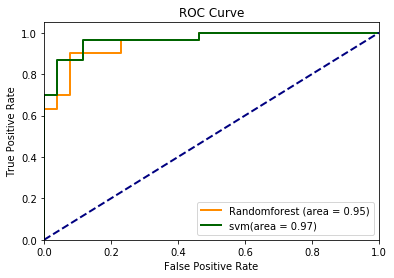

In [88]:
fpr_svm, tpr_svm, _ = sklearn.metrics.roc_curve(y_test, predicted_prob_svm[:, 1])
roc_auc_svm = sklearn.metrics.auc(fpr_svm, tpr_svm)

fpr_rf, tpr_rf, _ = sklearn.metrics.roc_curve(y_test, predicted_prob_rf[:, 1])
roc_auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange',
         lw=2, label='Randomforest (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_rf, tpr_rf, color='darkgreen',
         lw=2, label='svm(area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Summary

In [89]:
# Random Forest
print("RANDOM FOREST")
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted_rf)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted_rf)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted_rf)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted_rf)))
confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted_rf)
tn, fp, fn, tp = confusion.ravel()
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob_rf,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted_rf)))
print("\n")

## SVM
print("SVM")
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted_svm)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted_svm)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted_svm)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted_svm)))
confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted_svm)
tn, fp, fn, tp = confusion.ravel()
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob_svm,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted_svm)))
print("\n")

#Resnet
print("RESNET")
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=y_test, y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=y_test, y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=y_test, y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=y_test, y_pred=predicted)))
confusion = sklearn.metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
tn, fp, fn, tp = confusion.ravel()
print("False Positive Rate:" + str(fp/(tn+fp)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=y_test, y_score=np.argmax(predicted_prob,axis = 1))))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=y_test, y_score=np.argmax(predicted_prob,axis = 1))))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=y_test, y_pred=predicted)))

RANDOM FOREST

Accuracy: 0.9107142857142857
Precision: 0.9032258064516129
Recall: 0.9333333333333333
F-measure: 0.9180327868852459
False Positive Rate:0.11538461538461539
AUC: 0.908974358974359
Precision-Recall AUC: 0.8787250384024577
MCC: 0.8205830201566422


SVM

Accuracy: 0.8392857142857143
Precision: 0.92
Recall: 0.7666666666666667
F-measure: 0.8363636363636363
False Positive Rate:0.07692307692307693
AUC: 0.8615384615384616
Precision-Recall AUC: 0.8456043956043956
MCC: 0.691964991918924


RESNET

Accuracy: 0.8035714285714286
Precision: 0.7435897435897436
Recall: 0.9666666666666667
F-measure: 0.8405797101449275
False Positive Rate:0.38461538461538464
AUC: 0.7910256410256411
Precision-Recall AUC: 0.7366605616605617
MCC: 0.631323255446602
